In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from enum import StrEnum
from scipy.stats import spearmanr
sns.set_palette("tab20")

In [149]:
folder_to_models = "models_to_plot/russe2022"
model_files = list(Path(folder_to_models).glob("**/*.csv"))

In [150]:
model_files

[PosixPath('models_to_plot/russe2022/gpt-4.1-mini_few_shot.csv'),
 PosixPath('models_to_plot/russe2022/meta-llama_Llama-3.3-70B-Instruct-Turbo.csv')]

# RUSSE 2022

In [151]:
class BasicColumns(StrEnum):
    content_score = "content"
    fluency_score = "fluency"
    toxic_pairwise_score = "non-toxicity"
    J = "J"
    
class ModelsColumns(StrEnum):
    content_score = "content_score"
    fluency_score = "fluency_score"
    toxic_pairwise_score = "toxic_pairwise_score"
    J = "J"

In [152]:
df_path = Path(Path.cwd().parent, "dataset/test_all_metrics_russe2022.csv")
df_test = pd.read_csv(df_path)
df_test[BasicColumns.J] = df_test[BasicColumns.fluency_score] * df_test[BasicColumns.content_score] * df_test[BasicColumns.toxic_pairwise_score]


df_test["lang"] = "ru"

In [153]:
df_test.columns

Index(['original', 'method_output', 'fluency', 'non-toxicity', 'content', 'J',
       'participant_name', 'neutral_sentence_reference', 'chrf',
       'wmt22-comet-da', 'XCOMET-XL', 'XCOMET-LITE', 'XCOMET-XXL',
       'SIM-INPUT-GEN', 'SIM-GEN-REF', 'CLS_NEW_INPUT', 'CLS_NEW_GEN',
       'CLS_NEW_REF', 'CLS_OLD_INPUT', 'CLS_OLD_GEN', 'CLS_OLD_REF', 'lang'],
      dtype='object')

In [154]:
df_test_merged = df_test.copy()

In [155]:
lang_map_dict = {
    "Amharic": "am",
    "Chinese": "zh",
    "English": "en",
    "Spanish": "es",
    "Hindi": "hi",
    "German": "de",
    "Russian": "ru",
    "Ukrainian": "uk",
    "Arabic": "ar",
}

lang_map_dict_reverse = {v: k for k, v in lang_map_dict.items()}
df_test_merged["full_lang"] = df_test_merged["lang"].apply(lambda x: lang_map_dict_reverse[x])

In [156]:
df_test_merged.lang.value_counts()

lang
ru    4375
Name: count, dtype: int64

In [157]:
gold_J = df_test_merged[BasicColumns.content_score] * df_test_merged[BasicColumns.fluency_score] * df_test_merged[BasicColumns.toxic_pairwise_score]

In [158]:
model_suffix = "model_"

for f in model_files:
    _df = pd.read_csv(f)

    for c in list(ModelsColumns):
        if c.value != ModelsColumns.J:
            try:
                df_test_merged[f"{model_suffix}{f.stem}_{c.value}"] = _df[c.value].tolist()
            except:
                pass
    
    try:
        df_test_merged[f"{model_suffix}{f.stem}_{ModelsColumns.J}"] = df_test_merged[f"{model_suffix}{f.stem}_{ModelsColumns.fluency_score}"] * \
            df_test_merged[f"{model_suffix}{f.stem}_{ModelsColumns.content_score}"] * df_test_merged[f"{model_suffix}{f.stem}_{ModelsColumns.toxic_pairwise_score}"]
    except:
        pass

In [159]:
f.stem

'meta-llama_Llama-3.3-70B-Instruct-Turbo'

In [160]:
df_test_merged['model_gpt-4.1-mini_few_shot_J'] = df_test_merged["XCOMET-LITE"] * df_test_merged["CLS-PROD"] * df_test_merged["SIM-PROD"]
df_test_merged['model_meta-llama_Llama-3.3-70B-Instruct-Turbo_J'] = df_test_merged['chrf'] * df_test_merged['SIM-GEN-REF'] * df_test_merged['CLS_OLD_GEN']

KeyError: 'CLS-PROD'

In [161]:
df_test_merged.columns

Index(['original', 'method_output', 'fluency', 'non-toxicity', 'content', 'J',
       'participant_name', 'neutral_sentence_reference', 'chrf',
       'wmt22-comet-da', 'XCOMET-XL', 'XCOMET-LITE', 'XCOMET-XXL',
       'SIM-INPUT-GEN', 'SIM-GEN-REF', 'CLS_NEW_INPUT', 'CLS_NEW_GEN',
       'CLS_NEW_REF', 'CLS_OLD_INPUT', 'CLS_OLD_GEN', 'CLS_OLD_REF', 'lang',
       'full_lang', 'model_gpt-4.1-mini_few_shot_content_score',
       'model_gpt-4.1-mini_few_shot_fluency_score',
       'model_gpt-4.1-mini_few_shot_toxic_pairwise_score',
       'model_gpt-4.1-mini_few_shot_J',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_content_score',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_fluency_score',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_toxic_pairwise_score',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_J'],
      dtype='object')

In [162]:
sim_w_prod_score = []

c_ig = 0.4
c_gr = 0.6
for i, row in df_test_merged.iterrows():
    sim_w_prod_score.append(
        row['SIM-INPUT-GEN'] * c_ig + row['SIM-GEN-REF'] * c_gr
    )
    
df_test_merged["SIM-PROD"] = sim_w_prod_score


new_prod1 = []
new_prod2 = []

for i, row in df_test_merged.iterrows():
    new_prod1.append(
         max(
              (row["CLS_NEW_GEN"] + int(row["CLS_NEW_INPUT"] <= row["CLS_NEW_GEN"])) / 2,
              int(row["CLS_NEW_REF"] <= row["CLS_NEW_GEN"])
          )
    )
    
    new_prod2.append(
         max(
              (row["CLS_OLD_GEN"] + int(row["CLS_OLD_INPUT"] <= row["CLS_OLD_GEN"])) / 2,
              int(row["CLS_OLD_REF"] <= row["CLS_OLD_GEN"])
          )
    )
    
df_test_merged["CLS-PROD"] = new_prod1

In [169]:
# add J metrics
df_test_merged["J-PROD"] = df_test_merged["XCOMET-LITE"] * df_test_merged["CLS-PROD"] * df_test_merged["SIM-PROD"]
df_test_merged['J-OLD'] = df_test_merged['chrf'] * df_test_merged['SIM-GEN-REF'] * df_test_merged['CLS_OLD_GEN']

df_test_merged['J-XCOMET-LITE & gpt-4.1-mini_fewshot'] = df_test_merged["XCOMET-LITE"] * df_test_merged['model_gpt-4.1-mini_few_shot_toxic_pairwise_score']

In [170]:
df_test_merged.columns

Index(['original', 'method_output', 'fluency', 'non-toxicity', 'content', 'J',
       'participant_name', 'neutral_sentence_reference', 'chrf',
       'wmt22-comet-da', 'XCOMET-XL', 'XCOMET-LITE', 'XCOMET-XXL',
       'SIM-INPUT-GEN', 'SIM-GEN-REF', 'CLS_NEW_INPUT', 'CLS_NEW_GEN',
       'CLS_NEW_REF', 'CLS_OLD_INPUT', 'CLS_OLD_GEN', 'CLS_OLD_REF', 'lang',
       'full_lang', 'model_gpt-4.1-mini_few_shot_content_score',
       'model_gpt-4.1-mini_few_shot_fluency_score',
       'model_gpt-4.1-mini_few_shot_toxic_pairwise_score',
       'model_gpt-4.1-mini_few_shot_J',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_content_score',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_fluency_score',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_toxic_pairwise_score',
       'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_J', 'SIM-PROD',
       'CLS-PROD', 'J-PROD', 'J-OLD', 'J-XCOMET-LITE & gpt-4.1-mini_fewshot'],
      dtype='object')

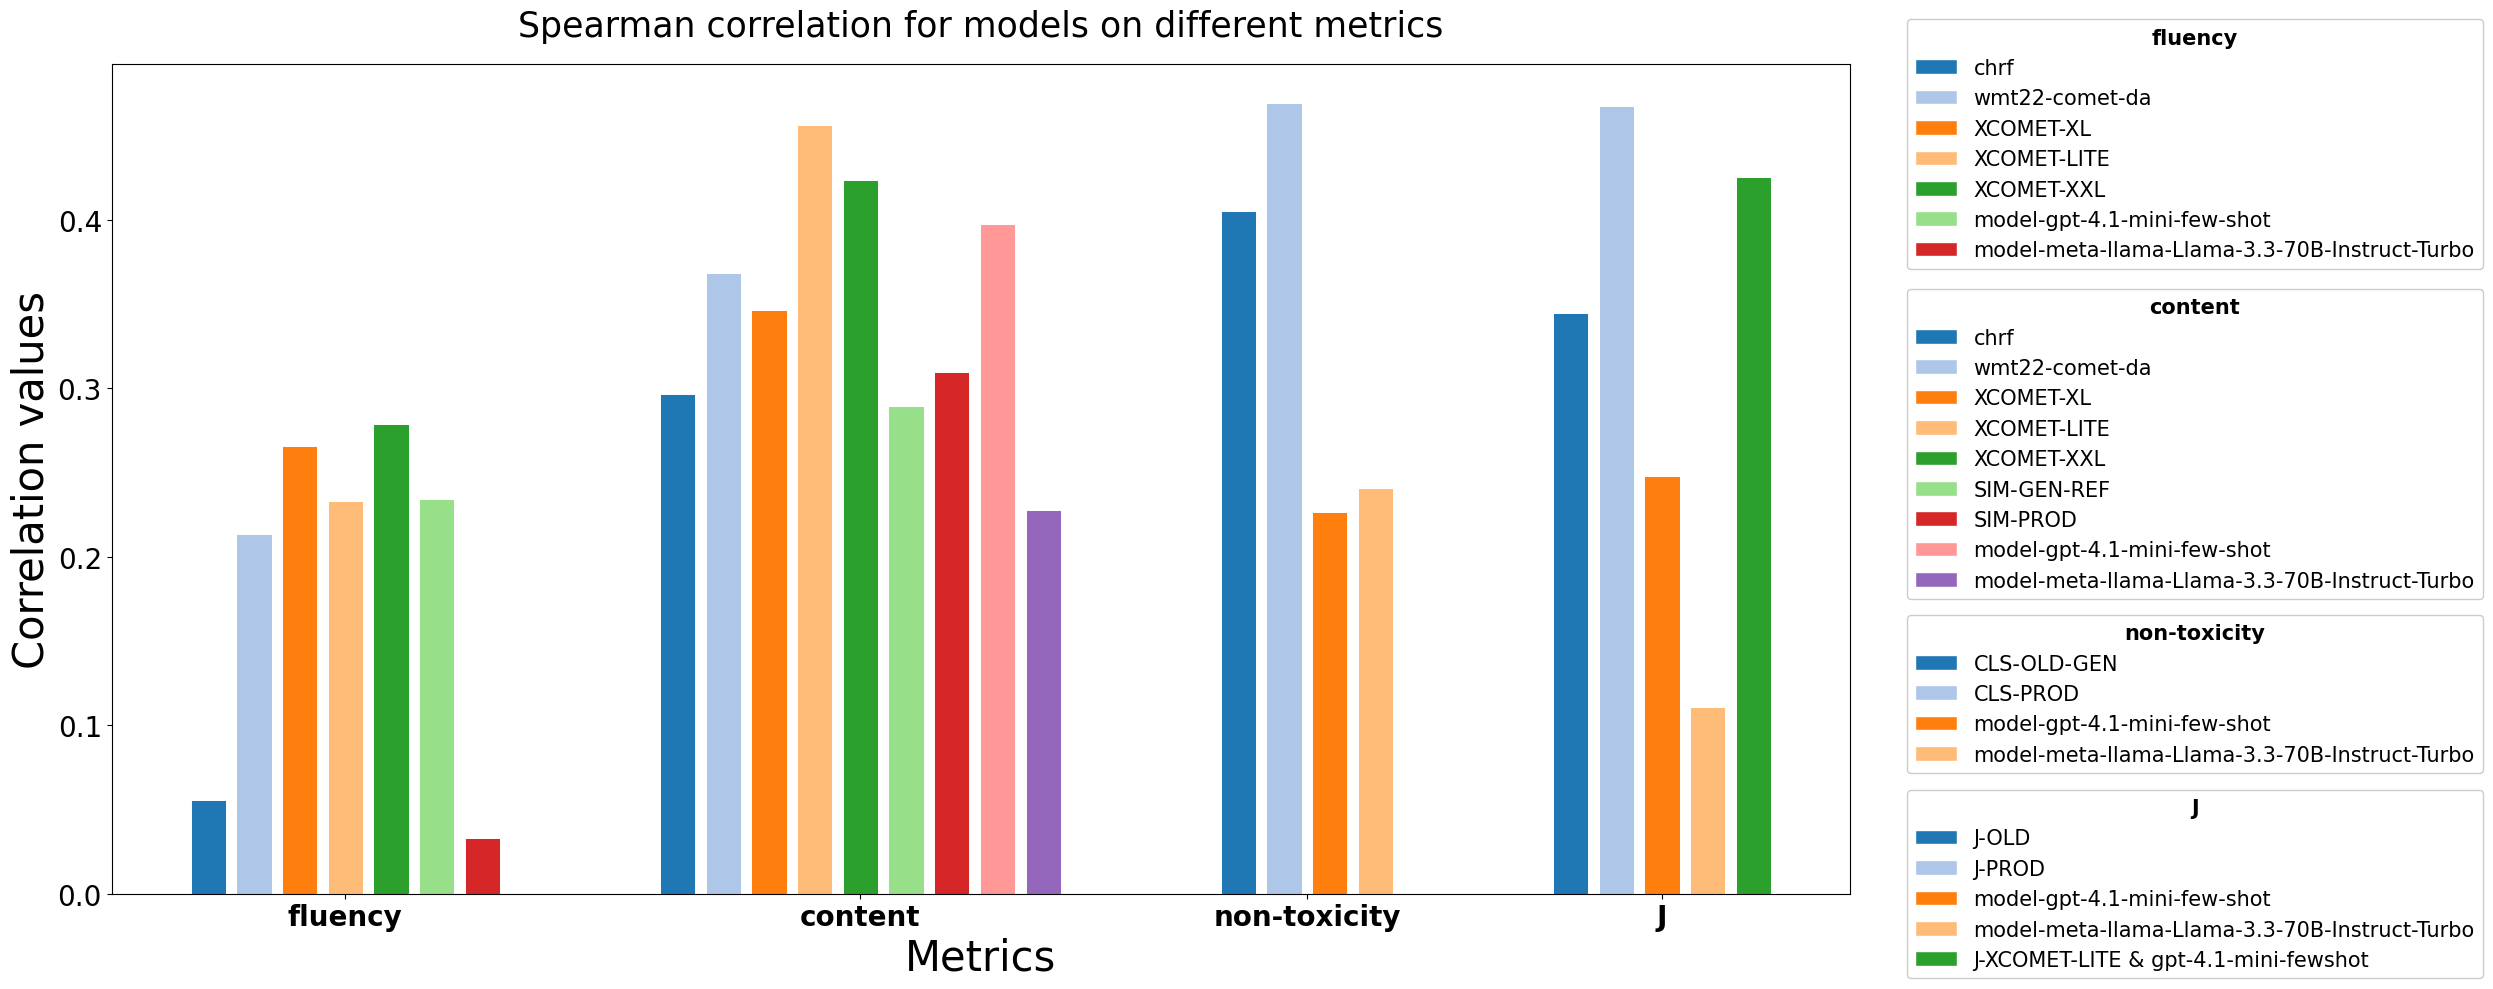

In [172]:
from matplotlib.patches import Patch
# Define your data groups
index_groups = {
    'fluency': ['chrf', 'wmt22-comet-da', 'XCOMET-XL', 'XCOMET-LITE', 'XCOMET-XXL', 'model_gpt-4.1-mini_few_shot_fluency_score', 'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_fluency_score'],
    'content': ['chrf', 'wmt22-comet-da', 'XCOMET-XL', 'XCOMET-LITE', 'XCOMET-XXL', 'SIM-GEN-REF', 'SIM-PROD', 'model_gpt-4.1-mini_few_shot_content_score', 'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_content_score'],
    'non-toxicity': ['CLS_OLD_GEN', 'CLS-PROD', 'model_gpt-4.1-mini_few_shot_toxic_pairwise_score', 'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_toxic_pairwise_score'],
    'J': ['J-OLD', 'J-PROD', 'model_gpt-4.1-mini_few_shot_J', 'model_meta-llama_Llama-3.3-70B-Instruct-Turbo_J', 'J-XCOMET-LITE & gpt-4.1-mini_fewshot']
}

# Calculate scores
models_res_dict = {}
for m, list_models in index_groups.items():
    if m not in models_res_dict:
        models_res_dict[m] = []

    for model in list_models:
        sub_df = df_test_merged[[m, model]].dropna()
        models_res_dict[m].append(
            spearmanr(
                sub_df[m].tolist(),
                sub_df[model].tolist(),
            ).statistic
        )

# Create figure with more width
fig, ax = plt.subplots(figsize=(22, 10))

# Style settings
bar_width = 0.18
group_spacing = 1.0
colors = plt.cm.tab20.colors

# Plot each index group
x_positions = []
current_x = 0

for group_idx, (group_name, metrics) in enumerate(index_groups.items()):
    positions = [current_x + i * (bar_width * 1.3) for i in range(len(metrics))]
    x_positions.append(np.mean(positions))
    
    for metric_idx, (metric, value) in enumerate(zip(metrics, models_res_dict[group_name])):
        ax.bar(positions[metric_idx], value, width=bar_width,
               color=colors[metric_idx], 
               edgecolor='white', linewidth=0.7)
    
    current_x = max(positions) + group_spacing

# Configure axes
ax.set_xticks(x_positions)
ax.set_xticklabels(index_groups.keys(), fontsize=20, weight='bold')
ax.set_xlabel('Metrics', fontsize=30)
ax.set_ylabel('Correlation values', fontsize=30)
ax.set_title('Spearman correlation for models on different metrics', fontsize=25, pad=20)
# ax.grid(axis='y', alpha=0.3)

# Create separate legends - this is the fixed part!
legend_boxes = []
legend_y_positions = [0.85, 0.55, 0.3, 0.11]  # Vertical positions for legends

for idx, (group_name, metrics) in enumerate(index_groups.items()):
    # Create legend elements
    handles, labels = ax.get_legend_handles_labels()
    legend_elements = [Patch(facecolor=colors[i], edgecolor='white', 
                            label=metrics[i].replace("_fluency_score", "").replace("_content_score", "").replace("_toxic_pairwise_score", "").replace("_J", "").replace("_", "-")) for i in range(len(metrics))]
    
    # Add legend to figure (not axes) at specific position
    legend = fig.legend(handles=legend_elements, 
                       title=group_name,
                       loc='center',
                       bbox_to_anchor=(1, legend_y_positions[idx]),
                       frameon=True,
                       framealpha=1,
                       prop={'size': 15},
                       title_fontproperties={'size': 15, 'weight': 'bold'}
                       )
    legend_boxes.append(legend)

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space for legends

# plt.savefig("imgs/russe-2022-all.pdf", bbox_inches='tight')
plt.show()